Training the Baseline AVD DL model for 30 epochs on the non DA training data.
Note base script originates from https://github.com/atmguille/Violence-Detection-With-Human-Skeletons

In [1]:
# Use output of OpenPose with or without background
BACKGROUND = False
# Paths to videos for training
PATHS = ["/home/Datasets/RWF-2000", f"/home/Datasets/Openpose_RWF_blending"]

FRAME_FUNC = 'frame_diff'
# To use frame diff to weight t (current) or t+1
WEIGHT_CURRENT = True

In [2]:
import tensorflow as tf

2023-11-26 19:23:50.225590: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 19:23:50.291132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 19:23:50.291179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 19:23:50.291224: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 19:23:50.308013: I tensorflow/core/platform/cpu_feature_g

In [3]:
# !export TF_FORCE_GPU_ALLOW_GROWTH=True
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
    #tf.config.set_visible_devices(gpus[0:], 'GPU')

In [4]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2023-11-26 19:23:53.285515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22493 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-11-26 19:23:53.286343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22493 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:89:00.0, compute capability: 8.6
2023-11-26 19:23:53.287143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22493 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:b1:00.0, compute capability: 8.6
2023-11-26 19:23:53.287907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22493 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:b2:00.0, 

Number of devices: 4


Set seed

In [5]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

In [6]:
import numpy as np
import cv2

In [7]:
ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3

def load_videos(video_IDs: list, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)

    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))
    try:
        for i, video_ID in enumerate(video_IDs):
            cap = cv2.VideoCapture(video_ID)
            frames = []
            index = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if index in frames_idx:
                    frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                    if normalize:
                        frame /= 255.0
                    frames.append(frame)
                index += 1
            cap.release()

            videos[i,] = np.array(frames)
    except Exception as e:
        print(f'Error: {str(e)}')
        print(f'Error video_ID: {video_ID}')

    return videos

DataGenerator class to load videos per batch, in case all videos do not fit in memory

In [8]:
import gc
from tensorflow.keras import backend as K

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, paths: list = [''], video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.paths = paths
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        batch_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]
        input_videos = []
        
        for index, path in enumerate(self.paths):
            batch_IDs_full_path = [path+ID for ID in batch_IDs]

            videos = load_videos(batch_IDs_full_path, self.video_frames, self.video_width, 
                                         self.video_height, self.video_channels, self.dtype, self.normalize)
            
            input_videos.append(videos)
        
        labels = np.array([self.video_labels[ID] for ID in batch_IDs])
                    
        return input_videos, labels
            
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

## Videos to load

In [9]:
def get_slug_from_path(path):
    """
    Function to get slug from path
    slug must contain /train or /val because there are repeated names
    """
    # Try train index first
    index = path.rfind('/train/')
    if index == -1:
        index = path.rfind('/val/')
    return path[index:]

In [10]:
import glob

train_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/train/*/*')]
test_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/val/*/*')]

train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}


train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=64, paths=PATHS)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10, paths=PATHS)

# Frame functions

In [11]:
import tensorflow.keras.backend as K

def tf_frame_diff(video):
    return video[1:] - video[:-1]

def tf_frame_dist(video):
    video_diff = tf_frame_diff(video)
    return K.sqrt(K.sum(K.square(video_diff), axis=-1, keepdims=True))

if WEIGHT_CURRENT:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(-video_diff)
        video_diff_next = tf.nn.relu(video_diff)
        video_diff_next_norm = K.sqrt(K.sum(K.square(video_diff_next), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_next_norm])
else:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(video_diff)
        video_diff_prev = tf.nn.relu(-video_diff)
        video_diff_prev_norm = K.sqrt(K.sum(K.square(video_diff_prev), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_prev_norm])
    
frame_func_dict = {'frame_diff': tf_frame_diff, 'frame_dist': tf_frame_dist, 'frame_diff_dist_combined': tf_frame_diff_dist_combined}
frame_func = frame_func_dict[FRAME_FUNC]

# ConvLSTM

In [12]:
with strategy.scope():
    inputs_raw = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
    inputs_openpose = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))

    inputs_diff = tf.keras.layers.Lambda(lambda video: tf.map_fn(frame_func, video))(inputs_raw)
    inputs_to_weight = inputs_openpose[:, :-1] if WEIGHT_CURRENT else inputs_openpose[:, 1:]

    inputs_diff_norm = tf.keras.layers.BatchNormalization()(inputs_diff)
    inputs_diff_time_info_weight = tf.keras.layers.ConvLSTM2D(filters=9, kernel_size=(3, 3), return_sequences=True, data_format='channels_last', activation='tanh')(inputs_diff_norm)

    convolutional_layer = tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='relu')
    inputs_openpose_soft = tf.keras.layers.TimeDistributed(convolutional_layer)(inputs_to_weight)

    inputs_openpose_norm = tf.keras.layers.BatchNormalization(scale=False, center=False)(inputs_openpose_soft)

    inputs_weighted = tf.keras.layers.Add()([inputs_openpose_norm, inputs_diff_time_info_weight])

    x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs_weighted)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), depth_multiplier=2, activation='relu', data_format='channels_last')(x)

    x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

    x = tf.keras.layers.Dense(units=128, activation='relu')(x)
    x = tf.keras.layers.Dense(units=16, activation='relu')(x)
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

    model = tf.keras.Model([inputs_raw, inputs_openpose], outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 51, 100, 100, 3)]    0         []                            
                                                                                                  
 input_1 (InputLayer)        

In [13]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, verbose=2)

Epoch 1/30
INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 18 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/r

2023-11-26 19:24:57.679302: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 19:24:57.727036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 19:24:57.765720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 19:24:57.832415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 19:25:05.835808: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9a968adf30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 19:25:05.835864: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-11-26 19:25:05.835874: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2023-11-26 19:25:05.835884: I tensorflo

21/21 - 677s - loss: 0.6957 - accuracy: 0.5186 - val_loss: 0.6927 - val_accuracy: 0.5000 - 677s/epoch - 32s/step
Epoch 2/30
21/21 - 670s - loss: 0.6921 - accuracy: 0.5074 - val_loss: 0.6896 - val_accuracy: 0.6150 - 670s/epoch - 32s/step
Epoch 3/30
21/21 - 665s - loss: 0.6730 - accuracy: 0.6667 - val_loss: 0.6403 - val_accuracy: 0.7000 - 665s/epoch - 32s/step
Epoch 4/30
21/21 - 666s - loss: 0.6139 - accuracy: 0.6652 - val_loss: 0.5752 - val_accuracy: 0.7300 - 666s/epoch - 32s/step
Epoch 5/30
21/21 - 673s - loss: 0.5531 - accuracy: 0.7232 - val_loss: 0.5109 - val_accuracy: 0.7600 - 673s/epoch - 32s/step
Epoch 6/30
21/21 - 667s - loss: 0.5171 - accuracy: 0.7522 - val_loss: 0.5954 - val_accuracy: 0.6750 - 667s/epoch - 32s/step
Epoch 7/30
21/21 - 661s - loss: 0.4847 - accuracy: 0.7775 - val_loss: 0.4572 - val_accuracy: 0.8000 - 661s/epoch - 31s/step
Epoch 8/30
21/21 - 664s - loss: 0.4670 - accuracy: 0.7842 - val_loss: 0.5583 - val_accuracy: 0.7150 - 664s/epoch - 32s/step
Epoch 9/30
21/21 - 

# Model performance

In [14]:
model.save('final_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


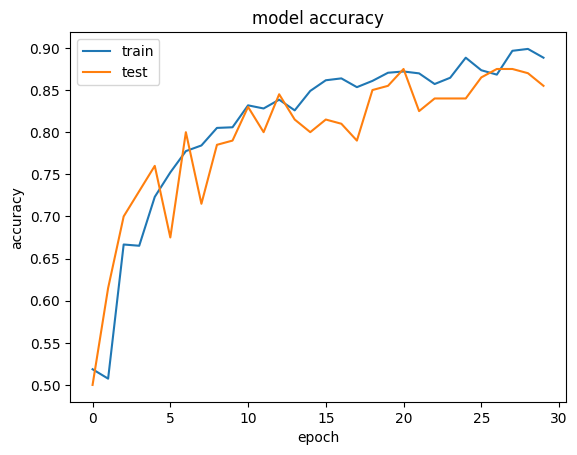

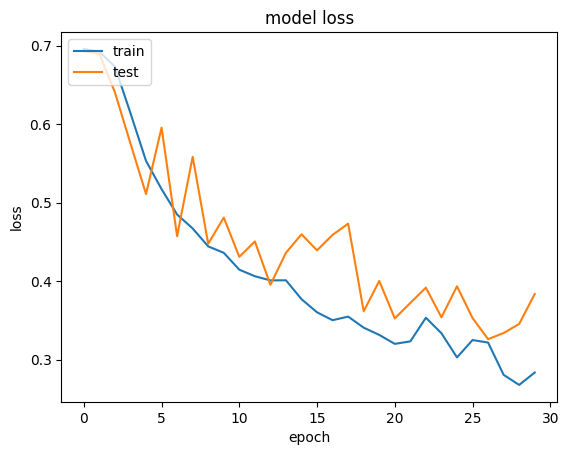

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss.png')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy.png')